In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
# 동일한 결과를 재현하기 위해서 random seed 고정
import numpy as np
np.random.seed(777)

In [4]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

1. 데이터 준비

In [5]:
from tensorflow.keras.datasets import reuters

import numpy as np

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

2.데이터 전처리

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

In [12]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Using TensorFlow backend.


In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

3. 네트워크 정의

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

4. 모델 컴파일

In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

5. 모델 학습

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 310us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 101us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 102us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 102us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 100us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 100us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 101us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


6. 학습 과정 확인

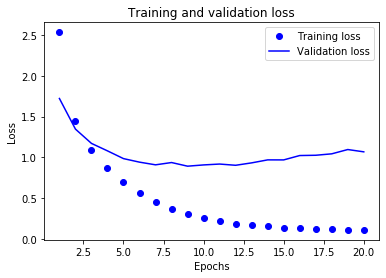

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

7. (과대적합 되기 전까지)모델 학습

In [18]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 130us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 100us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 101us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 100us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 100us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 100us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 101us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

8. 학습된 모델로 새로운 데이터 예측

In [19]:
predictions = model.predict(x_test)

In [20]:
predictions[0].shape

(46,)

In [21]:
np.sum(predictions[0])

0.99999994

In [22]:
np.argmax(predictions[0])

3

sparse_categorical_crossentropy : label을 꼭

In [23]:
# mnist 에서 10개의 digit중에 2면 [0,0,1,0 ...] 하기 싫을 때 이거 쓰면 됨.
# label을 꼭 0부터 시작하는 값으로 설정해줘야함.
만
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

충분히 큰 층을 두어야 하는 이유

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

# Dense 개수 성능은 떨어질 수 있음. : 분류해야하는 카테고리가 64차원이었다가 4차원 표현으로 줄임
# output layer의 개수가 46인 것을 고려했을 때 4로 줄어든 시점에서 (bottle neck feature)
# 표현이 compaact하게 되면 괜찮지만 문제가 생길 수 있음.

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 160us/step - loss: 3.1696 - acc: 0.2433 - val_loss: 2.6142 - val_acc: 0.2740
Epoch 2/20
7982/7982 [==============================] - 1s 128us/step - loss: 2.0606 - acc: 0.5461 - val_loss: 1.7033 - val_acc: 0.5860
Epoch 3/20
7982/7982 [==============================] - 1s 129us/step - loss: 1.5012 - acc: 0.6233 - val_loss: 1.5122 - val_acc: 0.6390
Epoch 4/20
7982/7982 [==============================] - 1s 126us/step - loss: 1.2887 - acc: 0.6907 - val_loss: 1.4120 - val_acc: 0.6780
Epoch 5/20
7982/7982 [==============================] - 1s 130us/step - loss: 1.1457 - acc: 0.7159 - val_loss: 1.3673 - val_acc: 0.6830
Epoch 6/20
7982/7982 [==============================] - 1s 131us/step - loss: 1.0403 - acc: 0.7313 - val_loss: 1.3424 - val_acc: 0.6980
Epoch 7/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.9587 - acc: 0.7422 - val_loss: 1.3388 - val_acc: 0.7010
